In [8]:
# import general libraries
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from imblearn.over_sampling import SMOTE


In [9]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dataengineer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dataengineer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dataengineer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dataengineer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
#Modelling 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb  # Load this xgboost
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.chdir('/content/gdrive/MyDrive/CapstoneProject')  #change dir of working folder


In [ ]:
# Reading data from the the file 
data = pd.read_csv('sample30.csv' , encoding='latin-1')
print(len(data))
data.head()

30000


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [13]:
#Checking the number of id's with positive and negative sentiments at different ratings.
data.pivot_table(index ='user_sentiment', columns ='reviews_rating', values ='id', aggfunc='count')

reviews_rating,1,2,3,4,5
user_sentiment,,,,,
Negative,597,140,220,550,1860
Positive,787,280,1125,5470,18970


In [14]:
# Drop rows which contain any NaN value in the user sentiment column
print("Before Delete: ",len(data))
data.dropna( how='any', subset=['user_sentiment'],inplace=True )
#data_sent = data.dropna( how='any', subset=['user_sentiment'])
print("After Delete: ",len(data))

# checking class imbalance
#dfTemp = data.groupby(['user_sentiment_updated'])['id'].count()
dfTemp = data.groupby(['user_sentiment'])['id'].count()

dfTemp.head()

Before Delete:  30000
After Delete:  29999


user_sentiment
Negative     3367
Positive    26632
Name: id, dtype: int64

In [15]:
#Mapping the user sentiment with 1 and 0 as postitive and negative respectively.
data['user_sentiment_updated'] = data['user_sentiment'].map({'Positive':1, 'Negative':0})

data.describe(include = "all")

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,user_sentiment_updated
count,29999,29999,29999,29858,29999,29953,15932,27429,29999.000000,29999,29809,1929,169,29936,29999,29999.000000
unique,271,214,270,227,271,6857,2,2,NaN,27282,18534,977,41,24914,2,NaN
top,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2012-01-26T00:00:00.000Z,False,True,NaN,Good,Great Product,Chicago,CA,mike,Positive,NaN
freq,8545,10585,8545,8546,8545,1041,14498,25879,NaN,16,384,34,19,41,26632,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.483116,NaN,NaN,NaN,NaN,NaN,NaN,0.887763
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.988453,NaN,NaN,NaN,NaN,NaN,NaN,0.315663
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [16]:
#converting reviews_text into string
data['reviews_text'] = data['reviews_text'].astype('str')

# Remove punctuation 
data['reviews_text'] = data['reviews_text'].str.replace('[^\w\s]','')

#Converting to lower case
data['reviews_text']= data['reviews_text'].str.lower()

# Remove Stopwords
stop = stopwords.words('english')
data['reviews_text'] = data['reviews_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [17]:
# Function to scrub the words
def scrub_words(text):
    """Basic cleaning of texts."""
    
    # remove html markup
    text=re.sub("(<.*?>)"," ",text)
    
    # remove unneccessary words
    text = text.replace("!","")
    text = text.replace(":","")
    text = text.replace("_"," ")
    
    #remove non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
    
    #remove whitespace
    text = text.strip()
    text = re.sub(' +', ' ',text)
    
    return text

In [18]:

data['reviews_text']=data['reviews_text'].apply(lambda x: scrub_words(x))


In [19]:
#EDA on words
# bag of words model
vectorizer = CountVectorizer()
bow_model = vectorizer.fit_transform(data['reviews_text'])

# look at the dataframe
pd.DataFrame(bow_model.toarray(), columns = vectorizer.get_feature_names())

,aaa,aaaaaaaaaaaaaaaaa,aaaaahhhhhh,aaammmaaazing,aalot,aanyhwere,aaron,abandon,abandoned,abback,...,zombies,zombified,zone,zones,zoo,zoom,zorbas,zucchetta,zucchini,zyrtec
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
import requests
from nltk import FreqDist

word_frequency = FreqDist(data['reviews_text'])
word_frequency


FreqDist({'good': 46, 'great': 32, 'love': 25, 'great product': 18, 'ok': 6, 'excellent': 6, 'delicious': 5, 'awesome': 5, 'like': 5, 'taste great': 5, ...})

In [21]:
#looking at word frequency
labels = [element[0] for element in word_frequency.most_common(25)]
counts = [element[1] for element in word_frequency.most_common(25)]   
dictionary = {"word": labels, "frequency": counts}
dfTemp = pd.DataFrame(dictionary, columns=['word', 'frequency'])
dfTemp.head(25)

,word,frequency
0,good,46
1,great,32
2,love,25
3,great product,18
4,ok,6
5,excellent,6
6,delicious,5
7,awesome,5
8,like,5
9,taste great,5


<AxesSubplot:>

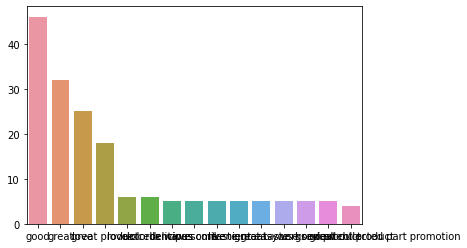

In [22]:
#Plotting the top 15 word frequencies
import seaborn as sns
def plot_word_frequency(words, top_n=10):
    word_freq = FreqDist(words)
    labels = [element[0] for element in word_freq.most_common(top_n)]
    counts = [element[1] for element in word_freq.most_common(top_n)]    
    plot = sns.barplot(labels, counts)
    return plot

plot_word_frequency(data['reviews_text'], 15)

In [23]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [24]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [25]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        #print(word)
        #print(tag)
        #print("***************")
        if tag is None:
            #if there is no available tag, append the token as is
            #lemmatized_sentence.append(word)
            lemmatized_sentence.append(lemmatizer.lemmatize(word))
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        #print(lemmatized_sentence)
    return " ".join(lemmatized_sentence)

In [26]:
data['reviews_text']=data['reviews_text'].apply(lambda x: lemmatize_sentence(x))

In [27]:
data['reviews_text']

0        love album good hip hop side current pop sound...
1                good flavor review collect part promotion
2                                              good flavor
3        read review look buy one couple lubricant ulti...
4        husband buy gel u gel caused irritation felt l...
                               ...                        
29995    get conditioner influenster try im love far oi...
29996    love receive review purpose influenster leave ...
29997    first love smell product wash hair smooth easy...
29998    receive influenster never go back anything els...
29999    receive product complimentary influenster real...
Name: reviews_text, Length: 29999, dtype: object

In [28]:
word_frequency = FreqDist(data['reviews_text'])
labels = [element[0] for element in word_frequency.most_common(25)]
counts = [element[1] for element in word_frequency.most_common(25)]   
dictionary = {"word": labels, "frequency": counts}
dfTemp = pd.DataFrame(dictionary, columns=['word', 'frequency'])
dfTemp.head(25)

,word,frequency
0,good,46
1,great,32
2,love,27
3,great product,18
4,taste great,9
5,taste good,7
6,ok,6
7,like,6
8,excellent,6
9,delicious,5


In [29]:
# Feature and Target Variable Split
x=data['reviews_text'] 
y=data['user_sentiment_updated']

In [30]:
no_of_classes= len(pd.Series(y).value_counts())
no_of_classes

2

In [31]:
#Distribution of the target variable data in terms of proportions.
for i in range(0,no_of_classes):
  print("Percent of {0}s: ".format(i), round(100*pd.Series(y).value_counts()[i]/pd.Series(y).value_counts().sum(),2), "%")

Percent of 0s:  11.22 %
Percent of 1s:  88.78 %


In [32]:
# Split the dataset into test and train
seed = 50 

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

In [33]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',    # Remove accents and perform other character normalization during the preprocessing step. 
    analyzer='word',            # Whether the feature should be made of word or character n-grams.
    token_pattern=r'\w{1,}',    # Regular expression denoting what constitutes a “token”, only used if analyzer == 'word'
    ngram_range=(1, 3),         # The lower and upper boundary of the range of n-values for different n-grams to be extracted
    stop_words='english',
    sublinear_tf=True)

word_vectorizer.fit(X_train)    # Fiting it on Train
train_word_features = word_vectorizer.transform(X_train)  # Transform on Train
train_word_features

<20999x353814 sparse matrix of type '<class 'numpy.float64'>'
	with 840418 stored elements in Compressed Sparse Row format>

In [34]:
print(train_word_features)

  (0, 350909)	0.059260838868932825
  (0, 338514)	0.1644934775545423
  (0, 338509)	0.14687848033714002
  (0, 333778)	0.1644934775545423
  (0, 333776)	0.15799230619067756
  (0, 333303)	0.07322798112025458
  (0, 313806)	0.1644934775545423
  (0, 313805)	0.1644934775545423
  (0, 313804)	0.13576465448360245
  (0, 276853)	0.1644934775545423
  (0, 276852)	0.1644934775545423
  (0, 276823)	0.11954478562892111
  (0, 273219)	0.1644934775545423
  (0, 273215)	0.14687848033714002
  (0, 273165)	0.08332053024688182
  (0, 256649)	0.1644934775545423
  (0, 256647)	0.15799230619067756
  (0, 256591)	0.03517109455029374
  (0, 206920)	0.1644934775545423
  (0, 206919)	0.1644934775545423
  (0, 206894)	0.11530074188913211
  (0, 190019)	0.1644934775545423
  (0, 190017)	0.15799230619067756
  (0, 188890)	0.051102045940249224
  (0, 175370)	0.14687848033714002
  :	:
  (20998, 184264)	0.16676393517736798
  (20998, 183040)	0.051083890163241476
  (20998, 176114)	0.2338927029771427
  (20998, 176113)	0.2338927029771427
  

In [35]:
#pd.DataFrame(train_word_features.toarray(), columns = word_vectorizer.get_feature_names())

In [36]:
## transforming the train and test datasets
X_train_transformed = word_vectorizer.transform(X_train.tolist())
X_test_transformed = word_vectorizer.transform(X_test.tolist())

# # Print the shape of each dataset.
print('X_train_transformed', X_train_transformed.shape)
print('y_train', y_train.shape)
print('X_test_transformed', X_test_transformed.shape)
print('y_test', y_test.shape)

X_train_transformed (20999, 353814)
y_train (20999,)
X_test_transformed (9000, 353814)
y_test (9000,)


In [37]:
# Build the Base Logistic Regression model.

time1 = time.time()

logit = LogisticRegression()
logit.fit(X_train_transformed,y_train)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 6.16 seconds


In [38]:
# Prediction Train Data
y_pred_train= logit.predict(X_train_transformed)

#Model Performance on Train Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_train, y_train))
print(classification_report(y_pred_train, y_train))

Logistic Regression accuracy 0.8996142673460641
              precision    recall  f1-score   support

           0       0.11      0.98      0.19       253
           1       1.00      0.90      0.95     20746

    accuracy                           0.90     20999
   macro avg       0.55      0.94      0.57     20999
weighted avg       0.99      0.90      0.94     20999



In [39]:
# Prediction Test Data
y_pred_test = logit.predict(X_test_transformed)

#Model Performance on Test Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))

Logistic Regression accuracy 0.894
              precision    recall  f1-score   support

           0       0.07      0.88      0.13        80
           1       1.00      0.89      0.94      8920

    accuracy                           0.89      9000
   macro avg       0.53      0.88      0.54      9000
weighted avg       0.99      0.89      0.94      9000



In [40]:
# Handling Class Imbalance
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train_transformed_sm, y_train_sm = sm.fit_resample(X_train_transformed, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({1: 18646, 0: 2353})
After Counter({0: 18646, 1: 18646})


In [41]:
# Building the Logistic Regression model
time1 = time.time()

logit_sm = LogisticRegression()
logit_sm.fit(X_train_transformed_sm,y_train_sm)

time_taken = time.time() - time1
print('Time Taken in logestic regression with smote: {:.2f} seconds'.format(time_taken))

Time Taken in logestic regression with smote: 5.74 seconds


In [42]:
# Prediction Train Data
y_pred_train_sm= logit_sm.predict(X_train_transformed_sm)

#Model Performance on Train Dataset
print("Logistic Regression accuracy", accuracy_score(y_pred_train_sm, y_train_sm))
print(classification_report(y_pred_train_sm, y_train_sm))

Logistic Regression accuracy 0.9851710822696557
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     19053
           1       0.97      1.00      0.99     18239

    accuracy                           0.99     37292
   macro avg       0.99      0.99      0.99     37292
weighted avg       0.99      0.99      0.99     37292



In [43]:
# Prediction Test Data
y_pred_test = logit_sm.predict(X_test_transformed)

print("Logistic Regression accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))
print(confusion_matrix(y_pred_test, y_test))

Logistic Regression accuracy 0.9204444444444444
              precision    recall  f1-score   support

           0       0.62      0.66      0.64       958
           1       0.96      0.95      0.96      8042

    accuracy                           0.92      9000
   macro avg       0.79      0.80      0.80      9000
weighted avg       0.92      0.92      0.92      9000

[[ 628  330]
 [ 386 7656]]


In [44]:
# Building Random Forest Model.
time1 = time.time()

classifier = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
classifier.fit(X_train_transformed_sm,y_train_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Time Taken: 46.06 seconds


In [45]:
# Prediction Train Data
y_pred_train= classifier.predict(X_train_transformed_sm)

print("Random Forest Model accuracy", accuracy_score(y_pred_train, y_train_sm))
print(classification_report(y_pred_train, y_train_sm))

Random Forest Model accuracy 0.9997586613750938
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18651
           1       1.00      1.00      1.00     18641

    accuracy                           1.00     37292
   macro avg       1.00      1.00      1.00     37292
weighted avg       1.00      1.00      1.00     37292



In [46]:
# Prediction Test Data
y_pred_test = classifier.predict(X_test_transformed)

print("Random Forest Model accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))

Random Forest Model accuracy 0.9126666666666666
              precision    recall  f1-score   support

           0       0.34      0.75      0.47       462
           1       0.99      0.92      0.95      8538

    accuracy                           0.91      9000
   macro avg       0.66      0.83      0.71      9000
weighted avg       0.95      0.91      0.93      9000



Grid Search to Find Optimal Hyperparameters

In [47]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [400,500,600,700,800,900,1000], 
    'max_features': [5, 15.20,25]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, return_train_score=True,
                          cv = 3, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_transformed_sm, y_train_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

Fitting 3 folds for each of 252 candidates, totalling 756 fits
Time Taken: 1811.74 seconds


In [48]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.6679460118378523 using {'max_depth': 4, 'max_features': 25, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 1000}


In [49]:
# Building Random Forest Model.
time1 = time.time()

classifier = RandomForestClassifier(bootstrap=True,
                             max_depth=15,#4,
                             min_samples_leaf=100, 
                             min_samples_split=1000,#200,
                             max_features=35,#15,
                             n_estimators=4000)#500)
classifier.fit(X_train_transformed_sm,y_train_sm)

time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

# Prediction Train Data
y_pred_train= classifier.predict(X_train_transformed_sm)

print("Random Forest Model accuracy", accuracy_score(y_pred_train, y_train_sm))
print(classification_report(y_pred_train, y_train_sm))

Time Taken: 21.91 seconds
Random Forest Model accuracy 0.7469162286817548
              precision    recall  f1-score   support

           0       0.81      0.72      0.76     21112
           1       0.68      0.78      0.73     16180

    accuracy                           0.75     37292
   macro avg       0.75      0.75      0.75     37292
weighted avg       0.76      0.75      0.75     37292



In [50]:
time1 = time.time()
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic')
xgb_cfl.fit(X_train_transformed_sm, y_train_sm) 
time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

# Prediction Train Data
y_pred_train= xgb_cfl.predict(X_train_transformed_sm)

print("XGB Model accuracy", accuracy_score(y_pred_train, y_train_sm))
print(classification_report(y_pred_train, y_train_sm))

[17:26:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time Taken: 16.66 seconds
XGB Model accuracy 0.9600450498766492
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     19412
           1       0.94      0.98      0.96     17880

    accuracy                           0.96     37292
   macro avg       0.96      0.96      0.96     37292
weighted avg       0.96      0.96      0.96     37292



In [51]:
# Prediction Test Data
y_pred_test = xgb_cfl.predict(X_test_transformed)

print("XGB Model accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))

XGB Model accuracy 0.907
              precision    recall  f1-score   support

           0       0.73      0.57      0.64      1311
           1       0.93      0.96      0.95      7689

    accuracy                           0.91      9000
   macro avg       0.83      0.77      0.79      9000
weighted avg       0.90      0.91      0.90      9000



In [54]:
# A parameter grid for XGBoost
params = {
        'n_estimators' : [500, 750, 1000], # no of trees 
        'learning_rate' : [0.05, 0.1],  # eta
        'min_child_weight': [1, 5],
        'gamma': [0.1, 0.5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'max_depth': [5, 10, 15]
        }

folds = 2

param_comb = 10 #50

random_search = RandomizedSearchCV(xgb_cfl, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=folds, verbose=3, random_state=42)

random_search.fit(X_train_transformed_sm, y_train_sm)

print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ )
print('\n Best hyperparameters:')
print(random_search.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[21:46:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=750, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
            

In [55]:
time1 = time.time()

xgb_cfl = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',n_estimators=1000,learning_rate = 0.1, min_child_weight = 1, gamma = 0.1,subsample = 1, colsample_bytree = 1, max_depth = 10)
xgb_cfl.fit(X_train_transformed_sm, y_train_sm) 
time_taken = time.time() - time1
print('Time Taken: {:.2f} seconds'.format(time_taken))

# Prediction Train Data
y_pred_train= xgb_cfl.predict(X_train_transformed_sm)

print("XGB Model accuracy", accuracy_score(y_pred_train, y_train_sm))
print(classification_report(y_pred_train, y_train_sm))

[21:49:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time Taken: 213.12 seconds
XGB Model accuracy 0.9944492116271586
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     18825
           1       0.99      1.00      0.99     18467

    accuracy                           0.99     37292
   macro avg       0.99      0.99      0.99     37292
weighted avg       0.99      0.99      0.99     37292



In [56]:
# Prediction Test Data
y_pred_test = xgb_cfl.predict(X_test_transformed)

print("XGB Model accuracy", accuracy_score(y_pred_test, y_test))
print(classification_report(y_pred_test, y_test))

XGB Model accuracy 0.9314444444444444
              precision    recall  f1-score   support

           0       0.64      0.72      0.68       907
           1       0.97      0.96      0.96      8093

    accuracy                           0.93      9000
   macro avg       0.81      0.84      0.82      9000
weighted avg       0.94      0.93      0.93      9000



In [57]:
import pickle
with open ('model.pkl','wb') as fp:
    pickle.dump(xgb_cfl,fp)

XGBoost post paramter tuning is selected as final model as this has best accuracy and good class classification among all the models.

Recommendation System

In [58]:
# import libraties
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reading data from the the file 
ratings = pd.read_csv('sample30.csv' , encoding='latin-1')
print(len(ratings))
ratings.head()

30000


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [59]:
# Test and Train split of the dataset.
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.30, random_state=31)

print(train.shape)
print(test.shape)

(21000, 15)
(9000, 15)


User Based Similarity

In [60]:
# Pivot the train ratings' dataset into matrix format in which columns are products and the rows are users.

df_pivot = train.pivot_table(index ='reviews_username', columns ='name', values ='reviews_rating', aggfunc='count')
df_pivot = df_pivot.fillna(0)
df_pivot.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()
dummy_train = dummy_train.groupby(['reviews_username','name'])['reviews_rating'].count().reset_index()
dummy_train['rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)
#dummy_train.head(2)
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='name',
    values='rating'
).fillna(1)
dummy_train.head(2)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [62]:
#Using Cosine Similarity
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [63]:
user_correlation[user_correlation<0]=0
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.258199,0.000000,0.000000
00sab00,0.0,0.909205,0.0,0.0,0.0,0.0,0.0,0.0,2.663101,0.00000,...,0.0,0.0,0.0,0.707107,0.438529,0.0,0.0,2.898305,0.000000,0.577350
01impala,0.0,6.387952,0.0,0.0,0.0,0.0,0.0,0.0,2.247131,0.00000,...,0.0,0.5,0.0,0.801784,0.701646,0.0,0.0,8.838839,0.000000,0.707107
0325home,0.0,0.069338,0.0,0.0,0.0,0.0,0.0,0.0,1.132456,0.57735,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,3.736071,0.447214,0.000000
06stidriver,0.0,0.069338,0.0,0.0,0.0,0.0,0.0,0.0,1.132456,0.57735,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,3.736071,0.447214,0.000000


Checking top 5 recommendations

In [64]:
user_input = 'tony'
user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]

name
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total    73.718549
The Resident Evil Collection 5 Discs (blu-Ray)               36.065156
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)         24.012522
Red (special Edition) (dvdvideo)                             16.154429
Tostitos Bite Size Tortilla Chips                             8.840524
Name: tony, dtype: float64

Evaluating User Based Model

In [65]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
print(common.shape)
common.head()

(2049, 15)


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
20634,AVpfkak01cnluZ0-nJj6,Starbucks,"Food & Beverage,Coffee, Tea & Cocoa,Coffee,Foo...",American Coffee Partnership,Starbucks Iced Expresso Classics Vanilla Latte...,2016-04-21T00:00:00.000Z,False,True,5,Love it!,Love the taste! Would have highly recommended!,NaN,NaN,girlie,Positive
26479,AVpfPPkEilAPnD_xX3cP,Aveeno,"Personal Care,Sun Care,Featured Brands,Health ...",Aveeno Baby,Aveeno Baby Continuous Protection Lotion Sunsc...,2013-07-05T00:00:00Z,NaN,NaN,1,"My 6 year old daughter has sensitive skin, and...",Not sensitive enough,NaN,NaN,kasheville,Positive
15098,AVpf4oLxLJeJML43FcxC,Avery,"Office,Office Supplies,Office Organization,Bin...",Avery Dennison,Avery174 Ready Index Contemporary Table Of Con...,2009-08-11T00:00:00.000Z,NaN,True,5,"Wow, what a difference ease makes. Thanks for ...",Best Ever,NaN,NaN,arlene,Positive
17968,AVpfcu821cnluZ0-k8ep,Vaseline,"Personal Care,Skin Care,Lip Care,Beauty,Makeup...",UNILEVER,Vaseline Intensive Care Lip Therapy Cocoa Butter,2015-04-29T00:00:00.000Z,False,True,5,Love this product. Its amazing. Made my lips s...,wonderful,NaN,NaN,mimi3,Positive
28020,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...,2015-05-20T00:00:00.000Z,NaN,True,5,This movie is wonderful. It has a great story ...,Great Family Movie,NaN,NaN,movielover,Positive


In [66]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18242,18243,18244,18245,18246,18247,18248,18249,18250,18251
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
06stidriver,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [67]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T
print(user_correlation_df_3.shape)
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
dummy_test = common.copy()

dummy_test['rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='rating').fillna(0)
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head(2)

(1728, 1728)


name,100:Complete First Season (blu-Ray),"42 Dual Drop Leaf Table with 2 Madrid Chairs""",Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL",...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# Checking RMSE post Normalizing the data
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

MinMaxScaler(feature_range=(1, 5))
2.1745035722672728


Item Based Similarity

In [69]:
dummy_train = train.groupby(['reviews_username','name'])['reviews_rating'].mean().reset_index()
df_pivot = dummy_train.pivot(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,0325home,06stidriver,09mommy11,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,...,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zxcsdfd,zxjki,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
from sklearn.metrics.pairwise import pairwise_distances
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
item_correlation[item_correlation<0]=0
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)

dummy_train = train.copy()
dummy_train = dummy_train.groupby(['reviews_username','name'])['reviews_rating'].count().reset_index()
dummy_train['rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)
#dummy_train.head(2)
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot(
    index='reviews_username',
    columns='name',
    values='rating'
).fillna(1)

item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.023523,0.000000,0.000000
00sab00,0.0,0.001171,0.0,0.0,0.0,0.0,0.0,0.0,0.003316,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
01impala,0.0,0.048480,0.0,0.0,0.0,0.0,0.0,0.0,0.014725,0.000000,...,0.0,0.0,0.0,0.006729,0.002859,0.0,0.0,0.000000,0.000000,0.003386
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001334,0.004255,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.001556,0.001594,0.000000
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001334,0.004255,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.001556,0.001594,0.000000


Checking top 5 recommendation for a user in Item Based model

In [71]:
user_input = 'tony'
user_final_rating.loc[user_input].sort_values(ascending=False)[0:5]

name
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total    73.718549
The Resident Evil Collection 5 Discs (blu-Ray)               36.065156
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)         24.012522
Red (special Edition) (dvdvideo)                             16.154429
Tostitos Bite Size Tortilla Chips                             8.840524
Name: tony, dtype: float64

Evaluating Item Based Model

In [72]:
common =  test[test.name.isin(train.name)]
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)

list_name = common.name.tolist()
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))

dummy_test = common.copy()

dummy_test['rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [73]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

MinMaxScaler(feature_range=(1, 5))
3.560944979100902


User based model turns out to be the better model with lower RMSE value